[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SGhanbariHaez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SGhanbariHaez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\SGhanbariHaez\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SGhanbariHaez\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


{'longest_scenario': '[Name 1] and [Name 2] host a podcast, each contributing '
                     'differently—[Name 1] managing topics and [Name 2] '
                     'handling editing. [Name 1] researches potential guests, '
                     'prepares scripts, leads discussions, organizes interview '
                     'schedules, and curates content. [Name 2] records the '
                     'sessions, edits the audio for clarity and flow, uploads '
                     'the episodes, monitors sound quality, and formats the '
                     'content for different platforms. Together, they review '
                     'feedback from their audience, discuss areas for '
                     'improvement, adjust future content, and brainstorm new '
                     'ideas. Their teamwork ensures a polished and engaging '
                     'podcast experience for their listeners.',
 'longest_scenario_tokens': 60,
 'max_cosine_sim': 0.4095302092280093,
 'max_e

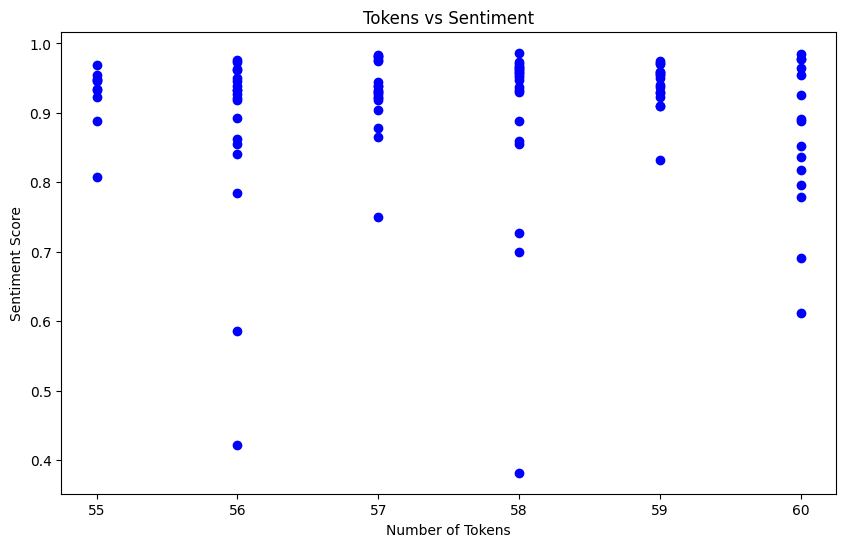

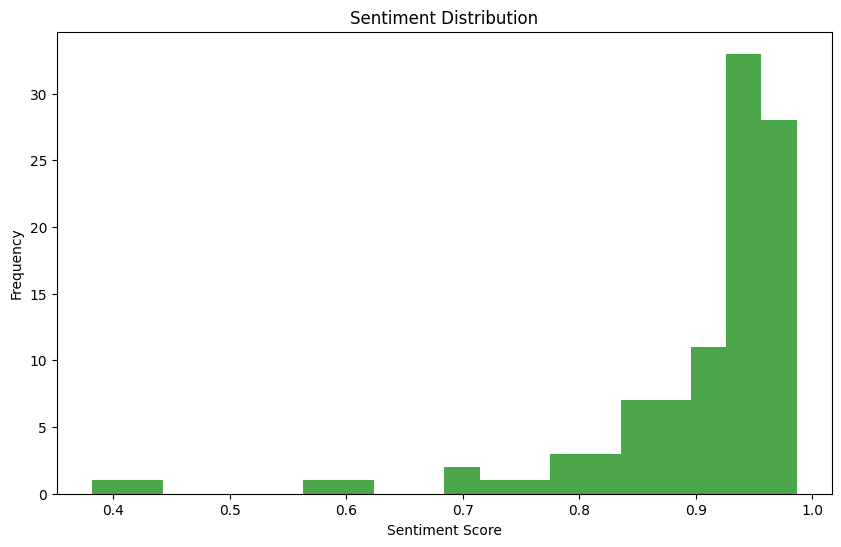

<module 'matplotlib.pyplot' from 'C:\\Python\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [37]:
import nltk
import json
import numpy as np
import statistics
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textstat import flesch_reading_ease, flesch_kincaid_grade
import spacy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
import pprint  # Import pprint module for better formatting

# Ensure you have the required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

# Load stop words
stop_words = set(stopwords.words('english'))

# Load spaCy model for Named Entity Recognition (NER) and Word Embeddings
nlp = spacy.load("en_core_web_md")

# Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

def clean_word_tokenize(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [
        token.lower() for token in tokens
        if token.isalpha() and token.lower() not in stop_words
    ]
    return cleaned_tokens

def calculate_ttr(text):
    tokens = clean_word_tokenize(text)
    ttr = len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0
    return ttr

def calculate_jaccard_similarity(scenario_data):
    n = len(scenario_data)
    jaccard_matrix = np.zeros((n, n))
    for i in range(n):
        set_i = set(scenario_data[i]['cleaned_tokens'])
        for j in range(i + 1, n):
            set_j = set(scenario_data[j]['cleaned_tokens'])
            intersection = set_i.intersection(set_j)
            union = set_i.union(set_j)
            similarity = len(intersection) / len(union) if union else 0
            jaccard_matrix[i][j] = similarity
            jaccard_matrix[j][i] = similarity
    return jaccard_matrix

def analyze_scenarios(scenarios):
    scenario_data = []
    token_counts = []
    sentence_counts = []
    readability_scores = []
    sentiments = []
    ttr_scores = []
    entity_counts = []
    pos_tags_list = []
    scenario_texts = []

    shortest_scenario = None
    longest_scenario = None
    shortest_scenario_tokens = float('inf')
    longest_scenario_tokens = 0

    for scenario in scenarios:
        text = " ".join(scenario.get('description', []))
        tokens = clean_word_tokenize(text)
        num_tokens = len(tokens)
        readability = flesch_reading_ease(text)
        sentiment_score = sia.polarity_scores(text)['compound']
        ttr = calculate_ttr(text)

        doc = nlp(text)
        entities = [ent.text for ent in doc.ents]
        entity_counts.append(len(entities))
        sentiments.append(sentiment_score)

        if num_tokens < shortest_scenario_tokens:
            shortest_scenario = text
            shortest_scenario_tokens = num_tokens
        if num_tokens > longest_scenario_tokens:
            longest_scenario = text
            longest_scenario_tokens = num_tokens

        scenario_info = {
            'scenario_number': scenario.get('number', 'Unknown'),
            'tokens': num_tokens,
            'sentences': len(sent_tokenize(text)),
            'cleaned_tokens': tokens,
            'text': text,
            'sentiment': sentiment_score,
            'readability_score': readability,
            'ttr': ttr,
            'entities': entities
        }
        scenario_data.append(scenario_info)
        token_counts.append(num_tokens)
        sentence_counts.append(len(sent_tokenize(text)))
        readability_scores.append(readability)
        scenario_texts.append(text)
        pos_tags_list.extend([tag for _, tag in pos_tag(tokens)])
        ttr_scores.append(ttr)

    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(scenario_texts)
    cosine_sim_matrix = cosine_similarity(X)

    mean_cosine_sim = np.mean(cosine_sim_matrix[np.triu_indices(len(scenario_texts), k=1)])
    max_cosine_sim = np.max(cosine_sim_matrix[np.triu_indices(len(scenario_texts), k=1)])
    min_cosine_sim = np.min(cosine_sim_matrix[np.triu_indices(len(scenario_texts), k=1)])

    jaccard_matrix = calculate_jaccard_similarity(scenario_data)
    upper_triangle = np.triu_indices(len(scenario_data), k=1)
    mean_jaccard_sim = np.mean(jaccard_matrix[upper_triangle])
    max_jaccard_sim = np.max(jaccard_matrix[upper_triangle])
    min_jaccard_sim = np.min(jaccard_matrix[upper_triangle])

    return {
        'scenario_data': scenario_data,
        'sentiments': sentiments,
        'shortest_scenario': shortest_scenario,
        'longest_scenario': longest_scenario,
        'shortest_scenario_tokens': shortest_scenario_tokens,
        'longest_scenario_tokens': longest_scenario_tokens,
        'min_tokens': min(token_counts),
        'max_tokens': max(token_counts),
        'mean_tokens': statistics.mean(token_counts),
        'std_dev_tokens': statistics.stdev(token_counts) if len(token_counts) > 1 else 0,
        'min_sentences': min(sentence_counts),
        'max_sentences': max(sentence_counts),
        'mean_sentences': statistics.mean(sentence_counts),
        'std_dev_sentences': statistics.stdev(sentence_counts) if len(sentence_counts) > 1 else 0,
        'min_sentiment': min(sentiments),
        'max_sentiment': max(sentiments),
        'mean_sentiment': statistics.mean(sentiments),
        'std_dev_sentiment': statistics.stdev(sentiments) if len(sentiments) > 1 else 0,
        'min_readability': min(readability_scores),
        'max_readability': max(readability_scores),
        'mean_readability': statistics.mean(readability_scores),
        'std_dev_readability': statistics.stdev(readability_scores) if len(readability_scores) > 1 else 0,
        'min_ttr': min(ttr_scores),
        'max_ttr': max(ttr_scores),
        'mean_ttr': statistics.mean(ttr_scores),
        'std_dev_ttr': statistics.stdev(ttr_scores) if len(ttr_scores) > 1 else 0,
        'min_entities': min(entity_counts),
        'max_entities': max(entity_counts),
        'mean_entities': statistics.mean(entity_counts),
        'std_dev_entities': statistics.stdev(entity_counts) if len(entity_counts) > 1 else 0,
        'pos_distribution': Counter(pos_tags_list),
        'readability_scores': readability_scores,
        'min_cosine_sim': min_cosine_sim,
        'max_cosine_sim': max_cosine_sim,
        'mean_cosine_sim': mean_cosine_sim,
        'min_jaccard_sim': min_jaccard_sim,
        'max_jaccard_sim': max_jaccard_sim,
        'mean_jaccard_sim': mean_jaccard_sim,
    }

# === Load Scenarios from JSON File ===
with open('RandomNeutralScenarios.json', 'r') as file:
    scenarios = json.load(file)

# Run analysis
result = analyze_scenarios(scenarios)

# Pretty print result
pprint.pprint(result, depth=2)

# Convert to DataFrame
df = pd.DataFrame({
    'Scenario Number': [item['scenario_number'] for item in result['scenario_data']],
    'Tokens': [item['tokens'] for item in result['scenario_data']],
    'Sentences': [item['sentences'] for item in result['scenario_data']],
    'Sentiment': [item['sentiment'] for item in result['scenario_data']],
    'Readability Score': [item['readability_score'] for item in result['scenario_data']],
    'TTR': [item['ttr'] for item in result['scenario_data']],
    'Entities': [len(item['entities']) for item in result['scenario_data']],
})

# Display analysis table
print("\n--- Scenario Analysis Table ---")
print(df)

# === Plotting ===

# Plot Tokens vs Sentiment
plt.figure(figsize=(10, 6))
plt.scatter(df['Tokens'], df['Sentiment'], color='blue')
plt.title("Tokens vs Sentiment")
plt.xlabel("Number of Tokens")
plt.ylabel("Sentiment Score")
plt.show()

# Plot Sentiment Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['Sentiment'], bins=20, color='green', alpha=0.7)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

# Plot Readability Scores Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['Readability Score'], bins=20, alpha=0.7)
plt.title("Readability Score Distribution")
plt.xlabel("Flesch Reading Ease Score")
plt.ylabel("Frequency")
plt.show()


# Plot Readability Scores Distribution
plt


In [38]:
import json

# Save results to a JSON file
def save_results_to_json(results, filename='Scenario_Statistics.json'):
    with open(filename, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Results saved to {filename}")

# Save the result to a JSON file
save_results_to_json(result)


Results saved to Scenario_Statistics.json
